## Solving the Hygrogen atom $\sigma$

Solve the matrix element for a set of k's and l = 1

<>:110: SyntaxWarning: invalid escape sequence '\s'
<>:110: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4262555437.py:110: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma$/Mbarn")
/tmp/ipython-input-4262555437.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


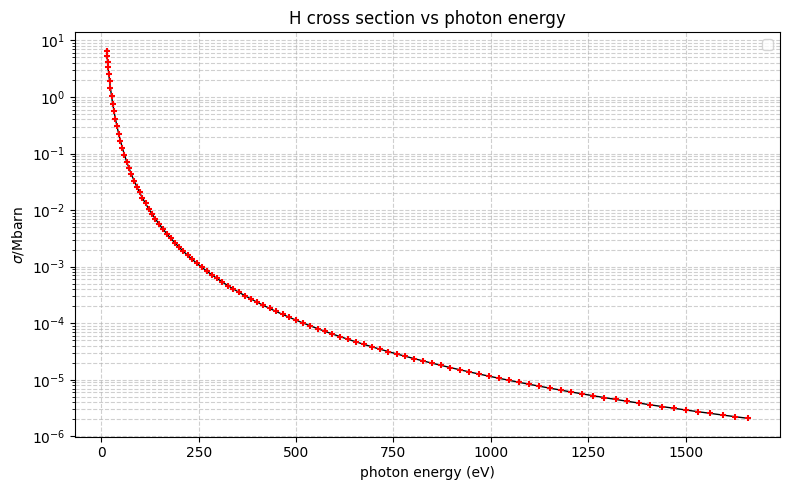

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.special import gamma as sp_gamma # Import gamma from scipy.special
import cmath # Import cmath for complex number functions


# radial eq
def radial_eq_rho(rho, y, Z, l, k):
    u, du = y
    d2u = -(1 + 2*Z/(k*rho) - l*(l + 1)/(rho)**2) * u
    return [du, d2u]

# asymptotic behaviour
def asymptotic_rho(rho, A, gamma, l, delta, k):

    return (A)*(1/np.sqrt(np.pi * k))*np.sin(rho - gamma * np.log(2 * rho) - 0.5 * np.pi * l + delta)

# numerical solution
def coulomb_RK_dimless(k, Z, l, rho_min=1e-5, N=50_000):
    gamma = Z / k
    rho_max= 800.0

    u0 = rho_min ** (l + 1)
    du0 = (l + 1) * rho_min ** l

    rho_eval = np.linspace(rho_min, rho_max, N)



    sol = solve_ivp(radial_eq_rho, (rho_min, rho_max), [u0, du0], method="RK45", t_eval=rho_eval, rtol=1e-9, atol=1e-12, args=(Z, l, k), first_step=1e-8)

    rho = sol.t
    u_unnormalized = sol.y[0] # Unnormalized solution

    # Asymptotic region for fitting
    match_start = rho_max * 0.88 # Use last 12% for fitting (adjusting match_start based on new rho_max)
    mask = rho > match_start
    rho_fit = rho[mask]
    u_fit_unnormalized = u_unnormalized[mask]


    # Calculate theoretical Coulomb phase shift for initial guess (optional, can use 0.0)
    sigma_l_complex = sp_gamma(l + 1 + 1j * gamma) # Use sp_gamma from scipy.special
    sigma_l = cmath.phase(sigma_l_complex)


    # Fitting the RK45 solution to the asymptotic form with A and delta_l as parameters
    # We are fitting for A and delta_fit, using the unnormalized solution
    # The asymptotic_rho function includes the (1/k)/sqrt(pi*k) factor, so A_fit will be the overall amplitude factor
    p0 = [1.0, sigma_l] # Initial guess for A and delta_fit


    popt, _ = curve_fit(lambda rho, A_fit, delta_fit: asymptotic_rho(rho, A_fit, gamma, l, delta_fit, k), rho_fit, u_fit_unnormalized, p0=p0, maxfev=10000)
    A_fit, delta_fit = popt

    u_normalized = u_unnormalized / A_fit

    # Ensure delta_fit is in the canonical range [-pi, pi].
    delta_fit = (delta_fit + np.pi) % (2 * np.pi) - np.pi


    r = rho / k
    return {"r": r, "u": u_normalized, "params": {"k": k, "Z": Z, "l": l, "gamma": gamma, "delta_fit": delta_fit, "A_fit": A_fit}}

# hydrogen 1s radial solution
def R_1s(r):
    return 2.0 * np.exp(-r)


# adaptative cutoff
def adaptive_cutoff(r, integrand, threshold=1e-6, window_fraction=0.05):
    abs_int = np.abs(integrand)
    max_val = np.max(abs_int)
    window = max(1, int(len(r) * window_fraction)) # Make window size a fraction of total points
    for i in range(len(r) - window):
        if np.all(abs_int[i:i+window] < threshold * max_val):
            return i
    return len(r)


k_values = np.linspace(0.2, 11, 100)
s_k = []
p_k = []
peV = []
alpha = 1/137.035999177
to_Mbarn = 28.00285

for k in k_values:

    result = coulomb_RK_dimless(k=k, Z=1, l=1)


    r, u = result["r"], result["u"]
    integrand = u * R_1s(r) * r**2
    PhE = 0.5*k**2 + 0.5
    p_k.append(PhE)
    peV.append(PhE*27.2114)
    cutoff_idx = adaptive_cutoff(r, integrand, threshold=1e-6)
    I = np.trapezoid(integrand[:cutoff_idx], r[:cutoff_idx])
    s_k.append(to_Mbarn*alpha*PhE*((8/3)*np.pi**2)*I**2)


# plot s(k)
plt.figure(figsize=(8,5))
plt.plot(peV, s_k, color='black', lw=1)  # thin black line
plt.scatter(peV, s_k, color='red', marker='+', s=20, zorder=5)  # red crosses
plt.xlabel("photon energy (eV)")
plt.ylabel("$\sigma$/Mbarn")
plt.title("H cross section vs photon energy")
plt.yscale("log")
plt.grid(True, which="both", ls="--", alpha=0.6)


plt.legend()
plt.tight_layout()
plt.show()

Comparison plot

/tmp/ipython-input-75785041.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


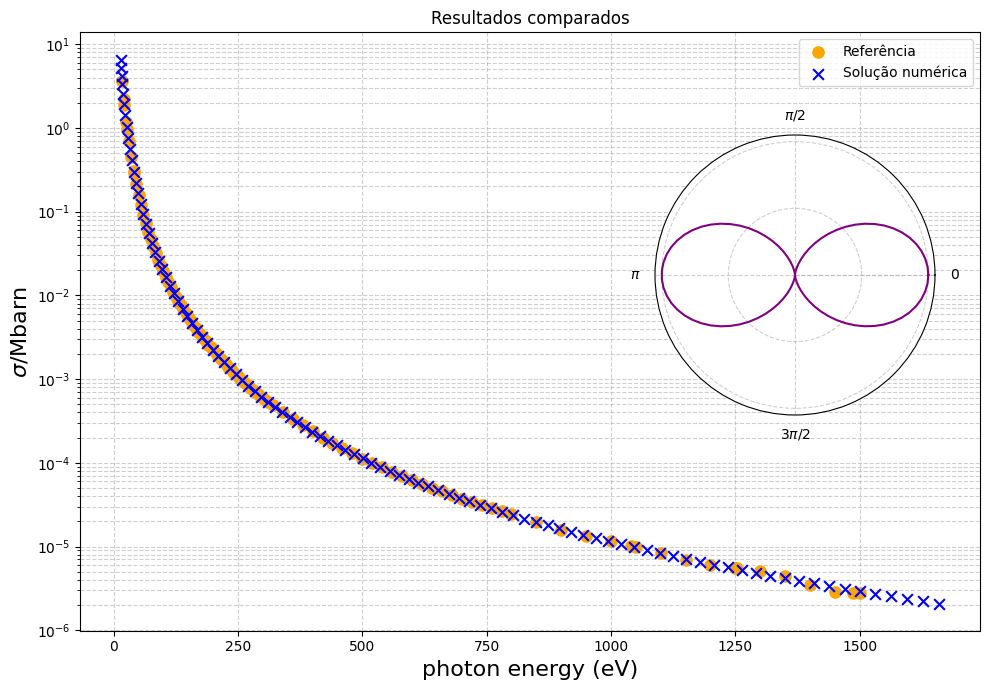

In [ ]:
# Extract data from the first cell (oOOIS8GCwL7T)
peV_method1 = peV
s_k_method1 = s_k


# Reading reference data from h1s.txt
fref = open("/content/h1s.txt", "r").readlines()
ref_energy = [float(line.split()[0]) for line in fref]
ref_cross_section = [float(line.split()[1]) for line in fref]

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 7)) # Create figure and axes objects

ax1.scatter(ref_energy, ref_cross_section, color='orange', s=65, label='Referência')

ax1.scatter(peV_method1, s_k_method1, color='blue', marker='x', s=60, zorder=5, label = 'Solução numérica')


ax1.set_yscale('log')
ax1.set_xlabel("photon energy (eV)", fontsize=16)
ax1.set_ylabel(r"$\sigma$/Mbarn", fontsize=16)
ax1.set_title("Resultados comparados")
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.6)

# Create inset plot as a polar plot
inset_ax = fig.add_axes([0.6, 0.4, 0.4, 0.4], polar=True) # [x0, y0, width, height] in figure coordinates, add polar=True

# Plot cosine squared in the inset (polar coordinates)
theta = np.linspace(0, 2*np.pi, 100)
r_values = np.cos(theta)**2
inset_ax.plot(theta, r_values, color='purple')

inset_ax.set_xticks(np.linspace(0, 2*np.pi, 5)) # Set ticks at 0, pi/2, pi, 3pi/2, 2pi
inset_ax.set_xticklabels([r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r' ']) # Label ticks
inset_ax.set_yticks([0.5, 1.0], labels=['', '']) # Set two radial ticks with empty labels
inset_ax.grid(True, ls='--', alpha=0.6) # Add grid to the polar plot


plt.tight_layout()
plt.show()